KNN and SVM are the top two models that minimize the "financial loss" - a metric which describes the total misallocation of funds and addresses the product categorization task from a pure optimization perspective.  It does not consider the nature of the errors - whether they are suitable for the actual use of the predictions - it simply aims to minimize the financial error assuming that the primary utility is found in accounting accuracies.  The financial error may not be suitable for e.g. reporting or forecasting tasks.

In [32]:
%load_ext autoreload
%autoreload 2
import utils.add_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
from autocat.data.datasets import get_training_data, get_totals_data
from autocat.data.filters import no_null_StdUnitsShipped_StdNetAmount, no_null_descriptions
from autocat.models import Model
from autocat.models.pipelines import get_scaled_pipeline_v1, get_unscaled_pipeline_v1
from autocat.models.evaluation import financial_loss_scorer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

import pandas as pd
import numpy as np
%matplotlib inline

### Training data

In [58]:
X, y = get_training_data('../data/processed/train_2018-08-24.csv', filters=[
    no_null_StdUnitsShipped_StdNetAmount
])

### Models

In [35]:
svm_model = Model.load('../models/svm-financial-loss_2018-09-04.model')
knn_model = Model.load('../models/knn-financial-loss_2018-09-04.model')

### Scorer

In [36]:
scorer = make_scorer(financial_loss_scorer, totals=get_totals_data(), greater_is_better=True)

### Cross Validation

In [48]:
CV = 100
svm_cv = cross_val_score(svm_model.get_model_pipeline(), X, y, scoring=scorer, cv=CV)
knn_cv = cross_val_score(knn_model.get_model_pipeline(), X, y, scoring=scorer, cv=CV)

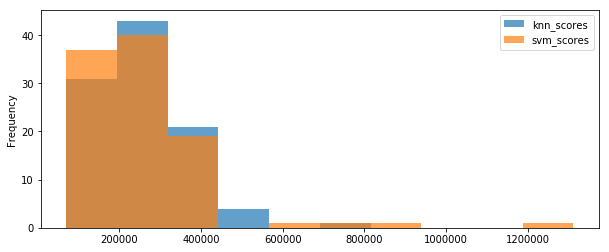

In [56]:
scores = pd.DataFrame({
    'svm_scores': svm_cv,
    'knn_scores': knn_cv,
})
scores.plot.hist(alpha=0.7, figsize=(10,4));

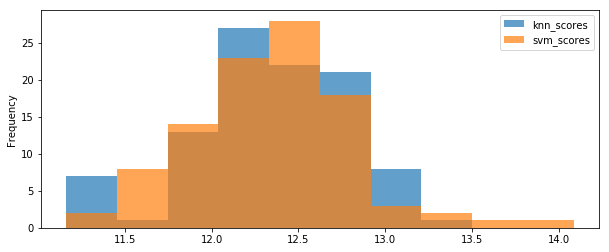

In [64]:
np.log(scores).plot.hist(alpha=0.7, figsize=(10,4));

In [57]:
scores.describe()

,knn_scores,svm_scores
count,100.000000,1.000000e+02
mean,252475.585800,2.617458e+05
std,108543.125504,1.622599e+05
min,70325.820000,8.651458e+04
25%,174774.055000,1.707802e+05
50%,228061.345000,2.357847e+05
75%,319924.560000,2.989878e+05
max,705252.940000,1.311753e+06


The means don't look significantly different but the knn model makes less extreme errors (though it's IQR is slightly higher than the SVM model's).  Based on this information, the KNN seems like the best model to use.  We could likely improve its performance with more tuning as discussed in the [2.0.1 notebook](2.0.1-knn-model-financial-loss-new.ipynb).